## Set parameters for the experiment

In [1]:
# %%writefile param_sets.json

seed_value = 123  # seed for the experiment
Trial = 2  # number of the experiment

period = 6  # the period to sample the data at. 1 period= 5 minutes

inputcols = ['oat', 'sat-oat']  # input predictors
x_loc = [0,1]  # input vars we want to plot in detailed plot
outputcols = ['hx_vlv1']  # output targets
input_timesteps = 1  # number of timesteps for the input sequence
output_timesteps = 1  # number of timesteps for the output sequence

# Smoothing
smooth_data = True  # whetter to smooth the data or not
order = 5  # order of the filer
T = 300  # sampling_period in seconds
fs = 1 / 300  # sample rate, Hz
cutoff = 0.0001  # desired cutoff frequency of the filter, Hz

# adjust out of phase data
adjust_lag = False  # whether to adjust the lag for certain columns
lag_columns = outputcols  # choose columns to adjust lag
data_lag = -1  # lag by how many periods: negative means shift column upwards

# aggregate data based on period
aggregate_data = True  # aggregate data or not
rolling_sum_target = []  # create sum aggregate for these columns
rolling_mean_target = ['oat', 'sat-oat','hx_vlv1']  # create mean aggregate for these columns

# create temporal batches of data: df2dflist
days, hours = 7, 0

# Custom way to create Training Data
data_weeks = 30  # Create a large initial block 6 months ~ 26 weeks of training and testing data
create_lag = 0  # Create further lags in the output
scaling = True  # Scale the input and output features
feature_range = (0, 1)  # Scaling range
reshaping = True  # reshape data according to (batch_size, time_steps, features)

# model configuration
modelconfig = {
    'lstm_hidden_units': 16,
    'lstm_no_layers': 1,
    'dense_hidden_units': 16,
    'dense_no_layers': 4,
    'retrain_from_layers': 0,
    'stateful': False,
    'train_batchsize':32,
    'test_batchsize':1, # we are doing online prediction
    'train_epochs': 5000,
}

# wheter doing adaptive for fixed learning
adaptive_control = True  # whether we relearn or keep it fixed
path = '../results/' + outputcols[0] + '_model{}/'.format(
    Trial) + 'adaptive/' * adaptive_control + 'fixed/' * (1 - adaptive_control)
#!rm -rf ../results/lstm_hwe_trial8/adaptive

#model design considerations
modeldesigndone = False  # whether model will be reinitialized
initial_epoch = 0  # the start epoch number for the training

# These are automatically superseded and ignored if adaptive_control is set to False
retain_prev_model = True  # retain weights of model from previous training
freeze_model = False  # freeze weights of certain layers
reinitialize = False  # reinitialize the weights of certain layers
model_saved = False  # whether model has been saved once
test_model_created = False  # create an idectical model for online predicton

# data used for learning the model
datapath = '../data/processed/buildingdata.pkl'

# additional info
addl = {
    'metainfo': 'create a diff of sat and oat for hot water energy prediction as it is useful. See 1.0.8',
    'names_abreviation': {
        'oat':'Outside Air Temperature',
        'orh':'Outside Air Relative Humidity',
        'sat-oat' : 'Difference of Supply Air and Outside Air Temps ',
        'ghi': 'Global Solar Irradiance',
        'hw_sf':'Hot Water System Flow Rate',
        'hx_vlv1':'Hot Water Valve %',
        'hw_st':'Hot Water Supply Temperature'
    }
}
x_lab = [addl['names_abreviation'][inputcols[i]] for i in x_loc]

## Set Seed in numpy, Keras and TF for reproducability and Import modules

In [2]:
import shutil
import glob
import os
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Enable '0' or disable '-1' GPU use
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# including the project directory to the notebook level
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import json
from tqdm import tqdm
import parse
import warnings
from matplotlib.dates import date2num

In [3]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    #tf.random.set_seed(seed_value)
    # for later versions: 
    tf.compat.v1.set_random_seed(seed_value)
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp

from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


## Create Folder to save models and tensorboard logs

In [4]:
# create the results directory
try:
    os.makedirs(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        try:
            shutil.rmtree(path + f)
        except NotADirectoryError:
            os.remove(path + f)
        
os.mkdir(path + 'loginfo')
os.mkdir(path + 'normalplots')
os.mkdir(path + 'detailedplots')

## Save the experiment parameters and configurations

In [5]:
#save the values
paramsdict = {
    
    'seed_value' : seed_value,
    
    'period':period,
    
    'inputcols':inputcols,
    'x_loc': x_loc,
    'outputcols':outputcols,
    'input_timesteps':input_timesteps,
    'output_timesteps':output_timesteps,
    
    'smooth_data': smooth_data,
    'order' : 5,
    'T' : T,
    'fs' : fs,
    'cutoff' : cutoff,
    
    'adjust_lag' : adjust_lag,
    'lag_columns' : lag_columns,
    'data_lag' : data_lag,
    
    'aggregate_data' : aggregate_data,
    'rolling_sum_target' : rolling_sum_target,
    'rolling_mean_target' : rolling_mean_target,
    
    'days':days,
    'hours':hours,
    
    'data_weeks' : data_weeks,
    'create_lag' : create_lag,
    'scaling' : scaling,
    'feature_range' : feature_range,
    'reshaping' : reshaping,
    
    'modelconfig' : modelconfig,
    
    'adaptive_control':adaptive_control,
    'path':path,
    
    'modeldesigndone' : modeldesigndone,
    'initial_epoch' : initial_epoch,
    
    'retain_prev_model' : retain_prev_model,
    'freeze_model' : freeze_model,
    'reinitialize' : reinitialize,
    'model_saved' : model_saved,
    'test_model_created': test_model_created,
    
    'datapath' : datapath,
    
    'addl' : addl,
}
    
# with open(path+'params.json', 'r') as fp:
#     param2dict = json.load(fp)

with open(path+'params.json', 'w') as fp:
    json.dump(paramsdict, fp, indent=4)

## Read the cleaned data

In [6]:
# read the pickled file for ahu data
dfdata = dp.readfile(datapath)

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

## Create additional Data columns as needed

In [7]:
df['sat-oat']= df['sat']-df['oat']

# show data
df.head()

,oat,sat,sat_stpt,orh,hwe,cwe,ghi,avg_stpt,flow,hw_rt,hw_sf,hw_st,hw_s_stp,hx_vlv1,sat-oat
2018-07-13 07:50:00,80.913567,79.320808,65.0,82.0,0.0,32.546185,562.0,69.52381,39.534317,89.589584,0.0,94.427994,90.0,0.276543,-1.592758
2018-07-13 07:55:00,80.913567,79.023285,65.0,82.0,0.0,29.293947,580.0,69.52381,39.809956,89.589584,0.0,94.125771,90.0,0.276543,-1.890282
2018-07-13 08:00:00,80.615402,79.023285,65.0,82.0,0.0,30.685425,597.0,69.52381,39.174774,89.589584,0.0,94.125771,90.0,0.276543,-1.592117
2018-07-13 08:05:00,80.303123,79.023285,65.0,82.0,0.0,30.074446,614.0,69.52381,35.745533,89.229790,0.0,93.816162,90.0,0.276543,-1.279839
2018-07-13 08:10:00,80.303123,79.023285,65.0,79.0,0.0,29.646845,625.0,69.52381,34.858036,89.229790,0.0,93.816162,90.0,0.276543,-1.279839


## Smooth the data

In [8]:
if smooth_data:
    df = dp.dfsmoothing(df=df,
                        column_names=list(df.columns),
                        order=order,
                        Wn=cutoff,
                        T=T)

## Adjust lag for certain columns if needed

In [9]:
if adjust_lag:
    df = dp.createlag(df, lag_columns, lag=data_lag)

## Create aggregate data: aggregate specified columns at specified intervals

In [10]:
# return a new column which is the sum of previous window_size values
def window_sum(df_, window_size: int, column_names: list):
    return df_[column_names].rolling(window=window_size, min_periods=window_size).sum()

# return a new column which is the average of previous window_size values
def window_mean(df_, window_size: int, column_names: list):
    return df_[column_names].rolling(window=window_size, min_periods=window_size).mean()

# rolling_sum_output = ['{}min_{}_sum'.format(5*period,target) for target in rolling_sum_target]
# rolling_mean_output = ['{}min_{}_mean'.format(5*period,target) for target in rolling_mean_target]

if aggregate_data:
    
    # rolling sum
    if rolling_sum_target:
        df[rolling_sum_target] =  window_sum(df, window_size=period, column_names=rolling_sum_target)
    
    # rolling mean
    if rolling_mean_target:
        df[rolling_mean_target] =  window_mean(df, window_size=period, column_names=rolling_mean_target)
    
    df = dp.dropNaNrows(df)
    
    # Sample the data at period intervals
    df = dp.sample_timeseries_df(df, period=period)

## Create temporal chunks of data

In [11]:
# Creating a list of "days" days dataframes for training
dflist = dp.df2dflist_alt(df[inputcols+outputcols],
                      subsequence=True,
                      period=period,
                      days=days,
                      hours=hours)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 76


## Custom way to create Weekly Training and Testing Data

In [12]:
from pandas import concat, Timedelta

def quickmerge(listdf):
    return concat(listdf)

weeklist = []  # create list of training, testing arrays

In [13]:
# select and merge data_weeks-1 worth of data
datablock_train_pre = dflist[0:data_weeks-1]
#merge them together
minibatch_train = quickmerge(datablock_train_pre)

# select weeks=1 worth of data
minibatch_test = dflist[data_weeks-1]

# splitvalue
splitvalue = minibatch_test.shape[0]
#merge test and train together
data_block = quickmerge([minibatch_train, minibatch_test])

# create numpy arrays
X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        data_block,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=scaling,
        feature_range=feature_range,
        reshaping=reshaping,
        lag=create_lag,
        split=splitvalue,
    input_timesteps=input_timesteps,
    output_timesteps = output_timesteps
    )

# select test ids for later plots
test_idx = minibatch_test.index

# append them
weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(minibatch_test.index[int(splitvalue/2)].year), 
                                      str(minibatch_test.index[int(splitvalue/2)].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })

In [14]:
for weekdata in dflist[data_weeks:]:
    
    # select and merge data_weeks-1 worth of data
    datablock_train_pre = datablock_train_pre[1:]+[minibatch_test]
    #merge them together
    minibatch_train = quickmerge(datablock_train_pre)
    
    # select weeks=1 worth of data
    minibatch_test = weekdata
    
    # splitvalue
    splitvalue = minibatch_test.shape[0]
    #merge test and train together
    data_block = quickmerge([minibatch_train, minibatch_test])

    # and add new week data from weekdata
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        data_block,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=scaling,
        feature_range=feature_range,
        reshaping=reshaping,
        lag=create_lag,
        split=splitvalue,
    input_timesteps=input_timesteps,
    output_timesteps = output_timesteps
    )

    # select test ids for later plots
    test_idx = minibatch_test.index

    weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(minibatch_test.index[int(splitvalue/2)].year), 
                                      str(minibatch_test.index[int(splitvalue/2)].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })
    
print('Length of weeklist: {}'.format(len(weeklist)))

Length of weeklist: 47


### Print size and shape of data to feed to the LSTM for sanity checks

In [15]:
for week in weeklist:
    for key,value in week.items():
        if (key != 'y_scaler') & (key != 'X_scaler') :
            print("name: {}, shape: {}".format(key, value.shape if not isinstance(value,str) else value))

name: Id, shape: Year-2019-Week-7
name: X_train, shape: (8465, 1, 2)
name: y_train, shape: (8465, 1, 1)
name: X_test, shape: (153, 1, 2)
name: y_test, shape: (153, 1, 1)
name: test_idx, shape: (153,)
name: Id, shape: Year-2019-Week-8
name: X_train, shape: (8306, 1, 2)
name: y_train, shape: (8306, 1, 1)
name: X_test, shape: (322, 1, 2)
name: y_test, shape: (322, 1, 1)
name: test_idx, shape: (322,)
name: Id, shape: Year-2019-Week-9
name: X_train, shape: (8296, 1, 2)
name: y_train, shape: (8296, 1, 1)
name: X_test, shape: (322, 1, 2)
name: y_test, shape: (322, 1, 1)
name: test_idx, shape: (322,)
name: Id, shape: Year-2019-Week-10
name: X_train, shape: (8289, 1, 2)
name: y_train, shape: (8289, 1, 1)
name: X_test, shape: (322, 1, 2)
name: y_test, shape: (322, 1, 1)
name: test_idx, shape: (322,)
name: Id, shape: Year-2019-Week-11
name: X_train, shape: (8316, 1, 2)
name: y_train, shape: (8316, 1, 1)
name: X_test, shape: (334, 1, 2)
name: y_test, shape: (334, 1, 1)
name: test_idx, shape: (334,

### Add weekly train test data to modelconfig dictionary for ease of training

In [16]:
modelconfig['weeklist'] = weeklist

## Clear the Tensorflow graph from previous training

In [17]:
try:
    del nn_model
except NameError:
    pass

K.clear_session()

##  Train the model

In [18]:
for weekno, BatchData in enumerate( tqdm(modelconfig['weeklist']) ):

    """Begin weekly training"""   
    X_train = BatchData['X_train']
    y_train = BatchData['y_train']

    try:
        del nn_model
    except NameError:
        pass

    K.clear_session()

    #Instantiate learner model
    nn_model = mp.simple_LSTM_model(path,
                                  inputdim=X_train.shape[-1],
                                  outputdim=y_train.shape[-1],
                                  input_timesteps=input_timesteps,
                                  output_timesteps = output_timesteps,
                                  period=period,
                                  stateful = modelconfig['stateful'],
                                  batch_size=modelconfig['train_batchsize'])

    # Desing model architecture
    nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                            densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                            dropoutlist=[[], []],
                            batchnormalizelist=[[], []])

    # load the trained model weights if we want to: here some layer weights may be reinitialized; see below
    if model_saved & retain_prev_model:
        nn_model.model.load_weights('IntermediateModel.h5')


    # compile model
    nn_model.model_compile() 
    
    # train the model for adaptive model and fixed after first round for fixed control
    if adaptive_control | (weekno==0):
        history = nn_model.train_model(X_train,
                                       y_train,
                                       epochs=modelconfig['train_epochs'],
                                       initial_epoch=initial_epoch)
        try:
            initial_epoch += len(history.history['loss'])
        except KeyError:
            pass

        # save the model only if trained at least once- needed for prediction model
        nn_model.model.save('IntermediateModel.h5')
        model_saved = True     
    """End Weekly Training"""
    
    
    """Begin Last Week Prediction"""
    
    y_scaler = BatchData['y_scaler']
    X_scaler = BatchData['X_scaler']
    X_test = BatchData['X_test']
    y_test = BatchData['y_test']
   
    try:
        del nn_model_pred
    except NameError:
        pass
    K.clear_session()

    # Separate predictor for predicting online: only difference is test batch size
    nn_model_pred = mp.simple_LSTM_model(path,
                                       inputdim=X_test.shape[-1],
                                       outputdim=y_test.shape[-1],
                                       input_timesteps=input_timesteps,
                                       output_timesteps = output_timesteps,
                                       period=period,
                                       stateful = modelconfig['stateful'],
                                       batch_size=modelconfig['test_batchsize'])

    # Desing model architecture
    nn_model_pred.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                            densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                            dropoutlist=[[], []],
                            batchnormalizelist=[[], []])


    # load the trained model weights
    nn_model_pred.model.load_weights('IntermediateModel.h5')
    # compile model
    nn_model_pred.model_compile()

    # evaluate the model for metrics at this stage
    # train and test plots as well as logged errors inside the text file
    preds_test = nn_model_pred.evaluate_model( X_test,
                                               y_test,
                                               y_scaler,
                                               save_plot_loc=path+'normalplots/',
                                               scaling=True,
                                               saveplot=True,
                                               Idx=BatchData['Id'],
                                               outputdim_names=outputcols)

    # do a detailed plot instead
    pu.detailedplot(period * 5,
                    xs = date2num(list(BatchData['test_idx'])),
                    outputdim=len(outputcols),
                    output_timesteps=output_timesteps,
                    input_timesteps=input_timesteps,
                    pred=preds_test,
                    target=y_test,
                    X_var=X_test,
                    x_loc=x_loc,
                    x_lab=x_lab,
                    saveloc=path + 'detailedplots/',
                    scaling=True,
                    Xscaler=X_scaler,
                    yscaler=y_scaler,
                    typeofplot='test',
                    Idx=BatchData['Id'])
    """End Last Week Prediction"""

    """Only execute when we are freezing LSTM and just training on Dense"""
    if adaptive_control:
        
        # freeze all but dense layers at the top and compile with new weights
        if freeze_model:
            for layer in nn_model.model.layers[:-modelconfig['retrain_from_layers']]:
                layer.trainable = False

        # for relearning, reinitialize top few layers
        if reinitialize:
            for layer in nn_model.model.layers[-modelconfig['retrain_from_layers']:]:
                layer.kernel.initializer.run(session=K.get_session())
                layer.bias.initializer.run(session=K.get_session())

        # recompile model
        if freeze_model | reinitialize:
            nn_model.model_compile()
            
            # save the model- needed for Keras limitations: Tensorboard crashes if we relearn on original model with
            # reinitialized weights; solution: we create new model and load these weights
            nn_model.model.save('IntermediateModel.h5')
            model_saved = True
            
            freeze_model = False
            reinitialize = False

  0%|          | 0/47 [00:00<?, ?it/s]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5000
 - 2s - loss: 0.0405
Epoch 2/5000
 - 1s - loss: 0.0282
Epoch 3/5000
 - 1s - loss: 0.0187
Epoch 4/5000
 - 1s - loss: 0.0174
Epoch 5/5000
 - 1s - loss: 0.0182
Epoch 6/5000
 - 1s - loss: 0.0179
Epoch 7/5000
 - 1s - loss: 0.0153
Epoch 8/5000
 - 1s - loss: 0.0149
Epoch 9/5000
 - 1s - loss: 0.0148
Epoch 10/5000
 - 1s - loss: 0.0148
Epoch 11/5000
 - 1s - loss: 0.0147
Epoch 12/5000
 - 1s - loss: 0.0143
Epoch 13/5000
 - 1s - loss: 0.0143
Epoch 14/5000
 - 1s - loss: 0.0143
Epoch 15/5000
 - 1s - loss: 0.0143
Epoch 16/5000
 - 1s - loss: 0.0142
Epoch 17/5000
 - 1s - loss: 0.0142
Epoch 18/5000
 - 1s - loss: 0.0142
Epoch 19/5000
 - 1s - loss: 0.0142
Epoch 20/5000
 - 1s - loss: 0.0142
Epoch 21/5000
 - 1s - loss: 0.0142
Epoch 22/5000
 - 1s - loss: 0.0142
Epoch 23/5000
 - 1s - loss: 0.0142
Epoch 24/5000
 - 1s - loss: 0.0142
Epoch 25/5000
 - 1s - loss: 0.0142
Epoch 26/5000
 - 1s - loss: 0.0142


  2%|▏         | 1/47 [00:52<40:31, 52.86s/it]

Epoch 39/5000
 - 2s - loss: 0.0159
Epoch 40/5000
 - 1s - loss: 0.0175
Epoch 41/5000
 - 1s - loss: 0.0169
Epoch 42/5000
 - 1s - loss: 0.0164
Epoch 43/5000
 - 1s - loss: 0.0147
Epoch 44/5000
 - 1s - loss: 0.0144
Epoch 45/5000
 - 1s - loss: 0.0144
Epoch 46/5000
 - 1s - loss: 0.0143
Epoch 47/5000
 - 1s - loss: 0.0143
Epoch 48/5000
 - 1s - loss: 0.0143
Epoch 49/5000
 - 1s - loss: 0.0138
Epoch 50/5000
 - 1s - loss: 0.0138
Epoch 51/5000
 - 1s - loss: 0.0138
Epoch 52/5000
 - 1s - loss: 0.0137
Epoch 53/5000
 - 1s - loss: 0.0137
Epoch 54/5000
 - 1s - loss: 0.0137
Epoch 55/5000
 - 1s - loss: 0.0137
Epoch 56/5000
 - 1s - loss: 0.0137
Epoch 57/5000
 - 1s - loss: 0.0137
Epoch 58/5000
 - 1s - loss: 0.0137
Epoch 59/5000
 - 1s - loss: 0.0137
Epoch 60/5000
 - 1s - loss: 0.0137
Epoch 61/5000
 - 1s - loss: 0.0137
Epoch 62/5000
 - 1s - loss: 0.0137
Epoch 63/5000
 - 1s - loss: 0.0137
Epoch 64/5000
 - 1s - loss: 0.0137
Epoch 65/5000
 - 1s - loss: 0.0137
Epoch 66/5000
 - 1s - loss: 0.0137
Epoch 67/5000
 - 1s 

  4%|▍         | 2/47 [01:47<40:06, 53.48s/it]

Epoch 79/5000
 - 2s - loss: 0.0161
Epoch 80/5000
 - 1s - loss: 0.0190
Epoch 81/5000
 - 1s - loss: 0.0170
Epoch 82/5000
 - 1s - loss: 0.0156
Epoch 83/5000
 - 1s - loss: 0.0149
Epoch 84/5000
 - 1s - loss: 0.0146
Epoch 85/5000
 - 1s - loss: 0.0144
Epoch 86/5000
 - 1s - loss: 0.0143
Epoch 87/5000
 - 1s - loss: 0.0143
Epoch 88/5000
 - 1s - loss: 0.0142
Epoch 89/5000
 - 1s - loss: 0.0142
Epoch 90/5000
 - 1s - loss: 0.0141
Epoch 91/5000
 - 1s - loss: 0.0141
Epoch 92/5000
 - 1s - loss: 0.0137
Epoch 93/5000
 - 1s - loss: 0.0136
Epoch 94/5000
 - 1s - loss: 0.0136
Epoch 95/5000
 - 1s - loss: 0.0136
Epoch 96/5000
 - 1s - loss: 0.0135
Epoch 97/5000
 - 1s - loss: 0.0135
Epoch 98/5000
 - 1s - loss: 0.0135
Epoch 99/5000
 - 1s - loss: 0.0135
Epoch 100/5000
 - 1s - loss: 0.0135
Epoch 101/5000
 - 1s - loss: 0.0135
Epoch 102/5000
 - 1s - loss: 0.0135
Epoch 103/5000
 - 1s - loss: 0.0135
Epoch 104/5000
 - 1s - loss: 0.0135
Epoch 105/5000
 - 1s - loss: 0.0135
Epoch 106/5000
 - 1s - loss: 0.0135
Epoch 107/500

  6%|▋         | 3/47 [02:46<40:19, 54.98s/it]

Epoch 122/5000
 - 2s - loss: 0.0169
Epoch 123/5000
 - 1s - loss: 0.0173
Epoch 124/5000
 - 1s - loss: 0.0166
Epoch 125/5000
 - 1s - loss: 0.0166
Epoch 126/5000
 - 1s - loss: 0.0165
Epoch 127/5000
 - 1s - loss: 0.0151
Epoch 128/5000
 - 1s - loss: 0.0143
Epoch 129/5000
 - 1s - loss: 0.0139
Epoch 130/5000
 - 1s - loss: 0.0138
Epoch 131/5000
 - 1s - loss: 0.0137
Epoch 132/5000
 - 1s - loss: 0.0136
Epoch 133/5000
 - 1s - loss: 0.0136
Epoch 134/5000
 - 1s - loss: 0.0135
Epoch 135/5000
 - 1s - loss: 0.0135
Epoch 136/5000
 - 1s - loss: 0.0134
Epoch 137/5000
 - 1s - loss: 0.0132
Epoch 138/5000
 - 1s - loss: 0.0133
Epoch 139/5000
 - 1s - loss: 0.0131
Epoch 140/5000
 - 1s - loss: 0.0127
Epoch 141/5000
 - 1s - loss: 0.0126
Epoch 142/5000
 - 1s - loss: 0.0126
Epoch 143/5000
 - 1s - loss: 0.0126
Epoch 144/5000
 - 1s - loss: 0.0125
Epoch 145/5000
 - 1s - loss: 0.0125
Epoch 146/5000
 - 1s - loss: 0.0125
Epoch 147/5000
 - 1s - loss: 0.0125
Epoch 148/5000
 - 1s - loss: 0.0125
Epoch 149/5000
 - 1s - loss:

  9%|▊         | 4/47 [03:47<40:42, 56.81s/it]

Epoch 167/5000
 - 2s - loss: 0.0147
Epoch 168/5000
 - 1s - loss: 0.0153
Epoch 169/5000
 - 1s - loss: 0.0156
Epoch 170/5000
 - 1s - loss: 0.0140
Epoch 171/5000
 - 1s - loss: 0.0128
Epoch 172/5000
 - 1s - loss: 0.0125
Epoch 173/5000
 - 1s - loss: 0.0124
Epoch 174/5000
 - 1s - loss: 0.0123
Epoch 175/5000
 - 1s - loss: 0.0122
Epoch 176/5000
 - 1s - loss: 0.0122
Epoch 177/5000
 - 1s - loss: 0.0121
Epoch 178/5000
 - 1s - loss: 0.0120
Epoch 179/5000
 - 1s - loss: 0.0119
Epoch 180/5000
 - 1s - loss: 0.0117
Epoch 181/5000
 - 1s - loss: 0.0116
Epoch 182/5000
 - 1s - loss: 0.0113
Epoch 183/5000
 - 1s - loss: 0.0112
Epoch 184/5000
 - 1s - loss: 0.0112
Epoch 185/5000
 - 1s - loss: 0.0110
Epoch 186/5000
 - 1s - loss: 0.0109
Epoch 187/5000
 - 1s - loss: 0.0109
Epoch 188/5000
 - 1s - loss: 0.0108
Epoch 189/5000
 - 1s - loss: 0.0107
Epoch 190/5000
 - 1s - loss: 0.0106
Epoch 191/5000
 - 1s - loss: 0.0106
Epoch 192/5000
 - 1s - loss: 0.0105
Epoch 193/5000
 - 1s - loss: 0.0104
Epoch 194/5000
 - 1s - loss:

 11%|█         | 5/47 [05:30<49:24, 70.58s/it]

Epoch 244/5000
 - 2s - loss: 0.0110
Epoch 245/5000
 - 1s - loss: 0.0112
Epoch 246/5000
 - 1s - loss: 0.0109
Epoch 247/5000
 - 1s - loss: 0.0106
Epoch 248/5000
 - 1s - loss: 0.0104
Epoch 249/5000
 - 1s - loss: 0.0103
Epoch 250/5000
 - 1s - loss: 0.0100
Epoch 251/5000
 - 1s - loss: 0.0098
Epoch 252/5000
 - 1s - loss: 0.0097
Epoch 253/5000
 - 1s - loss: 0.0096
Epoch 254/5000
 - 1s - loss: 0.0095
Epoch 255/5000
 - 1s - loss: 0.0094
Epoch 256/5000
 - 1s - loss: 0.0093
Epoch 257/5000
 - 1s - loss: 0.0093
Epoch 258/5000
 - 1s - loss: 0.0091
Epoch 259/5000
 - 1s - loss: 0.0083
Epoch 260/5000
 - 1s - loss: 0.0083
Epoch 261/5000
 - 1s - loss: 0.0082
Epoch 262/5000
 - 1s - loss: 0.0082
Epoch 263/5000
 - 1s - loss: 0.0081
Epoch 264/5000
 - 1s - loss: 0.0079
Epoch 265/5000
 - 1s - loss: 0.0079
Epoch 266/5000
 - 1s - loss: 0.0078
Epoch 267/5000
 - 1s - loss: 0.0078
Epoch 268/5000
 - 1s - loss: 0.0078
Epoch 269/5000
 - 1s - loss: 0.0078
Epoch 270/5000
 - 1s - loss: 0.0078
Epoch 271/5000
 - 1s - loss:

 13%|█▎        | 6/47 [06:35<47:04, 68.90s/it]

Epoch 291/5000
 - 2s - loss: 0.0093
Epoch 292/5000
 - 1s - loss: 0.0089
Epoch 293/5000
 - 1s - loss: 0.0088
Epoch 294/5000
 - 1s - loss: 0.0088
Epoch 295/5000
 - 1s - loss: 0.0088
Epoch 296/5000
 - 1s - loss: 0.0082
Epoch 297/5000
 - 1s - loss: 0.0080
Epoch 298/5000
 - 1s - loss: 0.0080
Epoch 299/5000
 - 1s - loss: 0.0079
Epoch 300/5000
 - 1s - loss: 0.0079
Epoch 301/5000
 - 1s - loss: 0.0078
Epoch 302/5000
 - 1s - loss: 0.0076
Epoch 303/5000
 - 1s - loss: 0.0076
Epoch 304/5000
 - 1s - loss: 0.0076
Epoch 305/5000
 - 1s - loss: 0.0076
Epoch 306/5000
 - 1s - loss: 0.0075
Epoch 307/5000
 - 1s - loss: 0.0075
Epoch 308/5000
 - 1s - loss: 0.0075
Epoch 309/5000
 - 1s - loss: 0.0075
Epoch 310/5000
 - 1s - loss: 0.0075
Epoch 311/5000
 - 1s - loss: 0.0075
Epoch 312/5000
 - 1s - loss: 0.0075
Epoch 313/5000
 - 1s - loss: 0.0075
Epoch 314/5000
 - 1s - loss: 0.0075
Epoch 315/5000
 - 1s - loss: 0.0075
Epoch 316/5000
 - 1s - loss: 0.0075
Epoch 317/5000
 - 1s - loss: 0.0075
Epoch 318/5000
 - 1s - loss:

 15%|█▍        | 7/47 [07:29<42:56, 64.42s/it]

Epoch 329/5000
 - 2s - loss: 0.0089
Epoch 330/5000
 - 1s - loss: 0.0091
Epoch 331/5000
 - 1s - loss: 0.0092
Epoch 332/5000
 - 1s - loss: 0.0087
Epoch 333/5000
 - 1s - loss: 0.0080
Epoch 334/5000
 - 1s - loss: 0.0077
Epoch 335/5000
 - 1s - loss: 0.0076
Epoch 336/5000
 - 1s - loss: 0.0076
Epoch 337/5000
 - 1s - loss: 0.0075
Epoch 338/5000
 - 1s - loss: 0.0075
Epoch 339/5000
 - 1s - loss: 0.0075
Epoch 340/5000
 - 1s - loss: 0.0073
Epoch 341/5000
 - 1s - loss: 0.0073
Epoch 342/5000
 - 1s - loss: 0.0073
Epoch 343/5000
 - 1s - loss: 0.0072
Epoch 344/5000
 - 1s - loss: 0.0072
Epoch 345/5000
 - 1s - loss: 0.0072
Epoch 346/5000
 - 1s - loss: 0.0072
Epoch 347/5000
 - 1s - loss: 0.0072
Epoch 348/5000
 - 1s - loss: 0.0072
Epoch 349/5000
 - 1s - loss: 0.0072
Epoch 350/5000
 - 1s - loss: 0.0072
Epoch 351/5000
 - 1s - loss: 0.0072
Epoch 352/5000
 - 1s - loss: 0.0072
Epoch 353/5000
 - 1s - loss: 0.0072
Epoch 354/5000
 - 1s - loss: 0.0072
Epoch 355/5000
 - 1s - loss: 0.0072
Epoch 356/5000
 - 1s - loss:

 17%|█▋        | 8/47 [08:22<39:47, 61.23s/it]

Epoch 367/5000
 - 2s - loss: 0.0089
Epoch 368/5000
 - 1s - loss: 0.0089
Epoch 369/5000
 - 1s - loss: 0.0090
Epoch 370/5000
 - 1s - loss: 0.0085
Epoch 371/5000
 - 1s - loss: 0.0080
Epoch 372/5000
 - 1s - loss: 0.0078
Epoch 373/5000
 - 1s - loss: 0.0077
Epoch 374/5000
 - 1s - loss: 0.0077
Epoch 375/5000
 - 1s - loss: 0.0076
Epoch 376/5000
 - 1s - loss: 0.0076
Epoch 377/5000
 - 1s - loss: 0.0074
Epoch 378/5000
 - 1s - loss: 0.0074
Epoch 379/5000
 - 1s - loss: 0.0074
Epoch 380/5000
 - 1s - loss: 0.0074
Epoch 381/5000
 - 1s - loss: 0.0073
Epoch 382/5000
 - 1s - loss: 0.0073
Epoch 383/5000
 - 1s - loss: 0.0073
Epoch 384/5000
 - 1s - loss: 0.0073
Epoch 385/5000
 - 1s - loss: 0.0073
Epoch 386/5000
 - 1s - loss: 0.0073
Epoch 387/5000
 - 1s - loss: 0.0073
Epoch 388/5000
 - 1s - loss: 0.0073
Epoch 389/5000
 - 1s - loss: 0.0073
Epoch 390/5000
 - 1s - loss: 0.0073
Epoch 391/5000
 - 1s - loss: 0.0073
Epoch 392/5000
 - 1s - loss: 0.0073
Epoch 393/5000
 - 1s - loss: 0.0073
Epoch 394/5000
 - 1s - loss:

 19%|█▉        | 9/47 [09:21<38:18, 60.49s/it]

Epoch 409/5000
 - 2s - loss: 0.0107
Epoch 410/5000
 - 1s - loss: 0.0116
Epoch 411/5000
 - 1s - loss: 0.0117
Epoch 412/5000
 - 1s - loss: 0.0111
Epoch 413/5000
 - 1s - loss: 0.0091
Epoch 414/5000
 - 1s - loss: 0.0091
Epoch 415/5000
 - 1s - loss: 0.0090
Epoch 416/5000
 - 1s - loss: 0.0090
Epoch 417/5000
 - 1s - loss: 0.0090
Epoch 418/5000
 - 1s - loss: 0.0087
Epoch 419/5000
 - 1s - loss: 0.0086
Epoch 420/5000
 - 1s - loss: 0.0086
Epoch 421/5000
 - 1s - loss: 0.0086
Epoch 422/5000
 - 1s - loss: 0.0086
Epoch 423/5000
 - 1s - loss: 0.0086
Epoch 424/5000
 - 1s - loss: 0.0086
Epoch 425/5000
 - 1s - loss: 0.0086
Epoch 426/5000
 - 1s - loss: 0.0086
Epoch 427/5000
 - 1s - loss: 0.0086
Epoch 428/5000
 - 1s - loss: 0.0086
Epoch 429/5000
 - 1s - loss: 0.0086
Epoch 430/5000
 - 1s - loss: 0.0086
Epoch 431/5000
 - 1s - loss: 0.0086
Epoch 432/5000
 - 1s - loss: 0.0086
Epoch 433/5000
 - 1s - loss: 0.0086
Epoch 434/5000
 - 1s - loss: 0.0086
Epoch 435/5000
 - 1s - loss: 0.0086
Epoch 436/5000
 - 1s - loss:

 21%|██▏       | 10/47 [10:16<36:12, 58.72s/it]

Epoch 448/5000
 - 2s - loss: 0.0113
Epoch 449/5000
 - 1s - loss: 0.0114
Epoch 450/5000
 - 1s - loss: 0.0115
Epoch 451/5000
 - 1s - loss: 0.0107
Epoch 452/5000
 - 1s - loss: 0.0098
Epoch 453/5000
 - 1s - loss: 0.0098
Epoch 454/5000
 - 1s - loss: 0.0097
Epoch 455/5000
 - 1s - loss: 0.0095
Epoch 456/5000
 - 1s - loss: 0.0094
Epoch 457/5000
 - 1s - loss: 0.0094
Epoch 458/5000
 - 1s - loss: 0.0094
Epoch 459/5000
 - 1s - loss: 0.0093
Epoch 460/5000
 - 1s - loss: 0.0093
Epoch 461/5000
 - 1s - loss: 0.0093
Epoch 462/5000
 - 1s - loss: 0.0093
Epoch 463/5000
 - 1s - loss: 0.0093
Epoch 464/5000
 - 1s - loss: 0.0093
Epoch 465/5000
 - 1s - loss: 0.0093
Epoch 466/5000
 - 1s - loss: 0.0093
Epoch 467/5000
 - 1s - loss: 0.0093
Epoch 468/5000
 - 1s - loss: 0.0093
Epoch 469/5000
 - 1s - loss: 0.0093
Epoch 470/5000
 - 1s - loss: 0.0093
Epoch 471/5000
 - 1s - loss: 0.0093
Epoch 472/5000
 - 1s - loss: 0.0093
Epoch 473/5000
 - 1s - loss: 0.0093
Epoch 474/5000
 - 1s - loss: 0.0093
Epoch 475/5000
 - 1s - loss:

 23%|██▎       | 11/47 [11:05<33:35, 56.00s/it]

Epoch 483/5000
 - 2s - loss: 0.0123
Epoch 484/5000
 - 1s - loss: 0.0116
Epoch 485/5000
 - 1s - loss: 0.0116
Epoch 486/5000
 - 1s - loss: 0.0115
Epoch 487/5000
 - 1s - loss: 0.0114
Epoch 488/5000
 - 1s - loss: 0.0114
Epoch 489/5000
 - 1s - loss: 0.0114
Epoch 490/5000
 - 1s - loss: 0.0113
Epoch 491/5000
 - 1s - loss: 0.0100
Epoch 492/5000
 - 1s - loss: 0.0099
Epoch 493/5000
 - 1s - loss: 0.0098
Epoch 494/5000
 - 1s - loss: 0.0098
Epoch 495/5000
 - 1s - loss: 0.0098
Epoch 496/5000
 - 1s - loss: 0.0096
Epoch 497/5000
 - 1s - loss: 0.0095
Epoch 498/5000
 - 1s - loss: 0.0095
Epoch 499/5000
 - 1s - loss: 0.0095
Epoch 500/5000
 - 1s - loss: 0.0094
Epoch 501/5000
 - 1s - loss: 0.0094
Epoch 502/5000
 - 1s - loss: 0.0094
Epoch 503/5000
 - 1s - loss: 0.0094
Epoch 504/5000
 - 1s - loss: 0.0094
Epoch 505/5000
 - 1s - loss: 0.0094
Epoch 506/5000
 - 1s - loss: 0.0094
Epoch 507/5000
 - 1s - loss: 0.0094
Epoch 508/5000
 - 1s - loss: 0.0094
Epoch 509/5000
 - 1s - loss: 0.0094
Epoch 510/5000
 - 1s - loss:

 26%|██▌       | 12/47 [12:03<32:54, 56.40s/it]

Epoch 524/5000
 - 2s - loss: 0.0116
Epoch 525/5000
 - 1s - loss: 0.0120
Epoch 526/5000
 - 1s - loss: 0.0117
Epoch 527/5000
 - 1s - loss: 0.0102
Epoch 528/5000
 - 1s - loss: 0.0101
Epoch 529/5000
 - 1s - loss: 0.0101
Epoch 530/5000
 - 1s - loss: 0.0101
Epoch 531/5000
 - 1s - loss: 0.0100
Epoch 532/5000
 - 1s - loss: 0.0098
Epoch 533/5000
 - 1s - loss: 0.0098
Epoch 534/5000
 - 1s - loss: 0.0098
Epoch 535/5000
 - 1s - loss: 0.0098
Epoch 536/5000
 - 1s - loss: 0.0097
Epoch 537/5000
 - 1s - loss: 0.0097
Epoch 538/5000
 - 1s - loss: 0.0097
Epoch 539/5000
 - 1s - loss: 0.0097
Epoch 540/5000
 - 1s - loss: 0.0097
Epoch 541/5000
 - 1s - loss: 0.0097
Epoch 542/5000
 - 1s - loss: 0.0097
Epoch 543/5000
 - 1s - loss: 0.0097
Epoch 544/5000
 - 1s - loss: 0.0097
Epoch 545/5000
 - 1s - loss: 0.0097
Epoch 546/5000
 - 1s - loss: 0.0097
Epoch 547/5000
 - 1s - loss: 0.0097
Epoch 548/5000
 - 1s - loss: 0.0097
Epoch 549/5000
 - 1s - loss: 0.0097
Epoch 550/5000
 - 1s - loss: 0.0097
Epoch 551/5000
 - 1s - loss:

 28%|██▊       | 13/47 [12:52<30:46, 54.32s/it]

Epoch 559/5000
 - 2s - loss: 0.0123
Epoch 560/5000
 - 1s - loss: 0.0137
Epoch 561/5000
 - 1s - loss: 0.0132
Epoch 562/5000
 - 1s - loss: 0.0129
Epoch 563/5000
 - 1s - loss: 0.0107
Epoch 564/5000
 - 1s - loss: 0.0105
Epoch 565/5000
 - 1s - loss: 0.0105
Epoch 566/5000
 - 1s - loss: 0.0104
Epoch 567/5000
 - 1s - loss: 0.0104
Epoch 568/5000
 - 1s - loss: 0.0104
Epoch 569/5000
 - 1s - loss: 0.0103
Epoch 570/5000
 - 1s - loss: 0.0102
Epoch 571/5000
 - 1s - loss: 0.0101
Epoch 572/5000
 - 1s - loss: 0.0101
Epoch 573/5000
 - 1s - loss: 0.0100
Epoch 574/5000
 - 1s - loss: 0.0100
Epoch 575/5000
 - 1s - loss: 0.0100
Epoch 576/5000
 - 1s - loss: 0.0100
Epoch 577/5000
 - 1s - loss: 0.0100
Epoch 578/5000
 - 1s - loss: 0.0100
Epoch 579/5000
 - 1s - loss: 0.0100
Epoch 580/5000
 - 1s - loss: 0.0100
Epoch 581/5000
 - 1s - loss: 0.0100
Epoch 582/5000
 - 1s - loss: 0.0100
Epoch 583/5000
 - 1s - loss: 0.0100
Epoch 584/5000
 - 1s - loss: 0.0100
Epoch 585/5000
 - 1s - loss: 0.0100
Epoch 586/5000
 - 1s - loss:

 30%|██▉       | 14/47 [13:43<29:20, 53.36s/it]

Epoch 595/5000
 - 2s - loss: 0.0127
Epoch 596/5000
 - 1s - loss: 0.0128
Epoch 597/5000
 - 1s - loss: 0.0126
Epoch 598/5000
 - 1s - loss: 0.0123
Epoch 599/5000
 - 1s - loss: 0.0122
Epoch 600/5000
 - 1s - loss: 0.0121
Epoch 601/5000
 - 1s - loss: 0.0121
Epoch 602/5000
 - 1s - loss: 0.0119
Epoch 603/5000
 - 1s - loss: 0.0119
Epoch 604/5000
 - 1s - loss: 0.0118
Epoch 605/5000
 - 1s - loss: 0.0118
Epoch 606/5000
 - 1s - loss: 0.0117
Epoch 607/5000
 - 1s - loss: 0.0117
Epoch 608/5000
 - 1s - loss: 0.0115
Epoch 609/5000
 - 1s - loss: 0.0113
Epoch 610/5000
 - 1s - loss: 0.0112
Epoch 611/5000
 - 1s - loss: 0.0110
Epoch 612/5000
 - 1s - loss: 0.0109
Epoch 613/5000
 - 1s - loss: 0.0108
Epoch 614/5000
 - 1s - loss: 0.0107
Epoch 615/5000
 - 1s - loss: 0.0107
Epoch 616/5000
 - 1s - loss: 0.0105
Epoch 617/5000
 - 1s - loss: 0.0104
Epoch 618/5000
 - 1s - loss: 0.0102
Epoch 619/5000
 - 1s - loss: 0.0101
Epoch 620/5000
 - 1s - loss: 0.0099
Epoch 621/5000
 - 1s - loss: 0.0098
Epoch 622/5000
 - 1s - loss:

 32%|███▏      | 15/47 [15:15<34:36, 64.89s/it]

Epoch 662/5000
 - 2s - loss: 0.0095
Epoch 663/5000
 - 1s - loss: 0.0096
Epoch 664/5000
 - 1s - loss: 0.0098
Epoch 665/5000
 - 1s - loss: 0.0084
Epoch 666/5000
 - 1s - loss: 0.0082
Epoch 667/5000
 - 1s - loss: 0.0081
Epoch 668/5000
 - 1s - loss: 0.0079
Epoch 669/5000
 - 1s - loss: 0.0079
Epoch 670/5000
 - 1s - loss: 0.0078
Epoch 671/5000
 - 1s - loss: 0.0079
Epoch 672/5000
 - 1s - loss: 0.0078
Epoch 673/5000
 - 1s - loss: 0.0077
Epoch 674/5000
 - 1s - loss: 0.0077
Epoch 675/5000
 - 1s - loss: 0.0077
Epoch 676/5000
 - 1s - loss: 0.0077
Epoch 677/5000
 - 1s - loss: 0.0077
Epoch 678/5000
 - 1s - loss: 0.0077
Epoch 679/5000
 - 1s - loss: 0.0077
Epoch 680/5000
 - 1s - loss: 0.0077
Epoch 681/5000
 - 1s - loss: 0.0077
Epoch 682/5000
 - 1s - loss: 0.0077
Epoch 683/5000
 - 1s - loss: 0.0077
Epoch 684/5000
 - 1s - loss: 0.0077
Epoch 685/5000
 - 1s - loss: 0.0077
Epoch 686/5000
 - 1s - loss: 0.0077
Epoch 687/5000
 - 1s - loss: 0.0077
Epoch 688/5000
 - 1s - loss: 0.0077
Epoch 689/5000
 - 1s - loss:

 34%|███▍      | 16/47 [16:06<31:24, 60.78s/it]

Epoch 699/5000
 - 2s - loss: 0.0105
Epoch 700/5000
 - 1s - loss: 0.0096
Epoch 701/5000
 - 1s - loss: 0.0096
Epoch 702/5000
 - 1s - loss: 0.0097
Epoch 703/5000
 - 1s - loss: 0.0092
Epoch 704/5000
 - 1s - loss: 0.0087
Epoch 705/5000
 - 1s - loss: 0.0084
Epoch 706/5000
 - 1s - loss: 0.0082
Epoch 707/5000
 - 1s - loss: 0.0081
Epoch 708/5000
 - 1s - loss: 0.0080
Epoch 709/5000
 - 1s - loss: 0.0079
Epoch 710/5000
 - 1s - loss: 0.0079
Epoch 711/5000
 - 1s - loss: 0.0079
Epoch 712/5000
 - 1s - loss: 0.0079
Epoch 713/5000
 - 1s - loss: 0.0078
Epoch 714/5000
 - 1s - loss: 0.0078
Epoch 715/5000
 - 1s - loss: 0.0077
Epoch 716/5000
 - 1s - loss: 0.0077
Epoch 717/5000
 - 1s - loss: 0.0077
Epoch 718/5000
 - 1s - loss: 0.0077
Epoch 719/5000
 - 1s - loss: 0.0077
Epoch 720/5000
 - 1s - loss: 0.0077
Epoch 721/5000
 - 1s - loss: 0.0077
Epoch 722/5000
 - 1s - loss: 0.0077
Epoch 723/5000
 - 1s - loss: 0.0077
Epoch 724/5000
 - 1s - loss: 0.0077
Epoch 725/5000
 - 1s - loss: 0.0077
Epoch 726/5000
 - 1s - loss:

 36%|███▌      | 17/47 [16:58<28:59, 57.98s/it]

Epoch 737/5000
 - 2s - loss: 0.0098
Epoch 738/5000
 - 1s - loss: 0.0102
Epoch 739/5000
 - 1s - loss: 0.0098
Epoch 740/5000
 - 1s - loss: 0.0093
Epoch 741/5000
 - 1s - loss: 0.0088
Epoch 742/5000
 - 1s - loss: 0.0085
Epoch 743/5000
 - 1s - loss: 0.0084
Epoch 744/5000
 - 1s - loss: 0.0083
Epoch 745/5000
 - 1s - loss: 0.0082
Epoch 746/5000
 - 1s - loss: 0.0082
Epoch 747/5000
 - 1s - loss: 0.0081
Epoch 748/5000
 - 1s - loss: 0.0081
Epoch 749/5000
 - 1s - loss: 0.0081
Epoch 750/5000
 - 1s - loss: 0.0080
Epoch 751/5000
 - 1s - loss: 0.0080
Epoch 752/5000
 - 1s - loss: 0.0080
Epoch 753/5000
 - 1s - loss: 0.0079
Epoch 754/5000
 - 1s - loss: 0.0079
Epoch 755/5000
 - 1s - loss: 0.0079
Epoch 756/5000
 - 1s - loss: 0.0079
Epoch 757/5000
 - 1s - loss: 0.0079
Epoch 758/5000
 - 1s - loss: 0.0079
Epoch 759/5000
 - 1s - loss: 0.0079
Epoch 760/5000
 - 1s - loss: 0.0079
Epoch 761/5000
 - 1s - loss: 0.0079
Epoch 762/5000
 - 1s - loss: 0.0079
Epoch 763/5000
 - 1s - loss: 0.0079
Epoch 764/5000
 - 1s - loss:

 38%|███▊      | 18/47 [17:51<27:24, 56.70s/it]

Epoch 777/5000
 - 2s - loss: 0.0109
Epoch 778/5000
 - 1s - loss: 0.0100
Epoch 779/5000
 - 1s - loss: 0.0103
Epoch 780/5000
 - 1s - loss: 0.0102
Epoch 781/5000
 - 1s - loss: 0.0095
Epoch 782/5000
 - 1s - loss: 0.0093
Epoch 783/5000
 - 1s - loss: 0.0091
Epoch 784/5000
 - 1s - loss: 0.0090
Epoch 785/5000
 - 1s - loss: 0.0089
Epoch 786/5000
 - 1s - loss: 0.0089
Epoch 787/5000
 - 1s - loss: 0.0089
Epoch 788/5000
 - 1s - loss: 0.0088
Epoch 789/5000
 - 1s - loss: 0.0088
Epoch 790/5000
 - 1s - loss: 0.0087
Epoch 791/5000
 - 1s - loss: 0.0087
Epoch 792/5000
 - 1s - loss: 0.0087
Epoch 793/5000
 - 1s - loss: 0.0087
Epoch 794/5000
 - 1s - loss: 0.0087
Epoch 795/5000
 - 1s - loss: 0.0087
Epoch 796/5000
 - 1s - loss: 0.0087
Epoch 797/5000
 - 1s - loss: 0.0086
Epoch 798/5000
 - 1s - loss: 0.0086
Epoch 799/5000
 - 1s - loss: 0.0086
Epoch 800/5000
 - 1s - loss: 0.0086
Epoch 801/5000
 - 1s - loss: 0.0086
Epoch 802/5000
 - 1s - loss: 0.0086
Epoch 803/5000
 - 1s - loss: 0.0086
Epoch 804/5000
 - 1s - loss:

 40%|████      | 19/47 [18:51<26:49, 57.49s/it]

Epoch 821/5000
 - 2s - loss: 0.0111
Epoch 822/5000
 - 1s - loss: 0.0108
Epoch 823/5000
 - 1s - loss: 0.0108
Epoch 824/5000
 - 1s - loss: 0.0107
Epoch 825/5000
 - 1s - loss: 0.0107
Epoch 826/5000
 - 1s - loss: 0.0107
Epoch 827/5000
 - 1s - loss: 0.0100
Epoch 828/5000
 - 1s - loss: 0.0097
Epoch 829/5000
 - 1s - loss: 0.0096
Epoch 830/5000
 - 1s - loss: 0.0095
Epoch 831/5000
 - 1s - loss: 0.0094
Epoch 832/5000
 - 1s - loss: 0.0094
Epoch 833/5000
 - 1s - loss: 0.0094
Epoch 834/5000
 - 1s - loss: 0.0094
Epoch 835/5000
 - 1s - loss: 0.0093
Epoch 836/5000
 - 1s - loss: 0.0093
Epoch 837/5000
 - 1s - loss: 0.0092
Epoch 838/5000
 - 1s - loss: 0.0092
Epoch 839/5000
 - 1s - loss: 0.0092
Epoch 840/5000
 - 1s - loss: 0.0092
Epoch 841/5000
 - 1s - loss: 0.0092
Epoch 842/5000
 - 1s - loss: 0.0092
Epoch 843/5000
 - 1s - loss: 0.0092
Epoch 844/5000
 - 1s - loss: 0.0092
Epoch 845/5000
 - 1s - loss: 0.0092
Epoch 846/5000
 - 1s - loss: 0.0092
Epoch 847/5000
 - 1s - loss: 0.0092
Epoch 848/5000
 - 1s - loss:

 43%|████▎     | 20/47 [19:45<25:24, 56.45s/it]

Epoch 861/5000
 - 2s - loss: 0.0110
Epoch 862/5000
 - 1s - loss: 0.0110
Epoch 863/5000
 - 1s - loss: 0.0110
Epoch 864/5000
 - 1s - loss: 0.0110
Epoch 865/5000
 - 1s - loss: 0.0102
Epoch 866/5000
 - 1s - loss: 0.0100
Epoch 867/5000
 - 1s - loss: 0.0099
Epoch 868/5000
 - 1s - loss: 0.0098
Epoch 869/5000
 - 1s - loss: 0.0098
Epoch 870/5000
 - 1s - loss: 0.0098
Epoch 871/5000
 - 1s - loss: 0.0097
Epoch 872/5000
 - 1s - loss: 0.0096
Epoch 873/5000
 - 1s - loss: 0.0096
Epoch 874/5000
 - 1s - loss: 0.0096
Epoch 875/5000
 - 1s - loss: 0.0096
Epoch 876/5000
 - 1s - loss: 0.0095
Epoch 877/5000
 - 1s - loss: 0.0095
Epoch 878/5000
 - 1s - loss: 0.0095
Epoch 879/5000
 - 1s - loss: 0.0095
Epoch 880/5000
 - 1s - loss: 0.0095
Epoch 881/5000
 - 1s - loss: 0.0095
Epoch 882/5000
 - 1s - loss: 0.0095
Epoch 883/5000
 - 1s - loss: 0.0095
Epoch 884/5000
 - 1s - loss: 0.0095
Epoch 885/5000
 - 1s - loss: 0.0095
Epoch 886/5000
 - 1s - loss: 0.0095
Epoch 887/5000
 - 1s - loss: 0.0095
Epoch 888/5000
 - 1s - loss:

 45%|████▍     | 21/47 [20:35<23:37, 54.54s/it]

Epoch 898/5000
 - 2s - loss: 0.0110
Epoch 899/5000
 - 1s - loss: 0.0116
Epoch 900/5000
 - 1s - loss: 0.0115
Epoch 901/5000
 - 1s - loss: 0.0123
Epoch 902/5000
 - 1s - loss: 0.0111
Epoch 903/5000
 - 1s - loss: 0.0108
Epoch 904/5000
 - 1s - loss: 0.0106
Epoch 905/5000
 - 1s - loss: 0.0105
Epoch 906/5000
 - 1s - loss: 0.0104
Epoch 907/5000
 - 1s - loss: 0.0103
Epoch 908/5000
 - 1s - loss: 0.0102
Epoch 909/5000
 - 1s - loss: 0.0102
Epoch 910/5000
 - 1s - loss: 0.0102
Epoch 911/5000
 - 1s - loss: 0.0100
Epoch 912/5000
 - 1s - loss: 0.0100
Epoch 913/5000
 - 1s - loss: 0.0100
Epoch 914/5000
 - 1s - loss: 0.0099
Epoch 915/5000
 - 1s - loss: 0.0099
Epoch 916/5000
 - 1s - loss: 0.0099
Epoch 917/5000
 - 1s - loss: 0.0099
Epoch 918/5000
 - 1s - loss: 0.0099
Epoch 919/5000
 - 1s - loss: 0.0099
Epoch 920/5000
 - 1s - loss: 0.0099
Epoch 921/5000
 - 1s - loss: 0.0099
Epoch 922/5000
 - 1s - loss: 0.0099
Epoch 923/5000
 - 1s - loss: 0.0099
Epoch 924/5000
 - 1s - loss: 0.0099
Epoch 925/5000
 - 1s - loss:

 47%|████▋     | 22/47 [21:33<23:10, 55.62s/it]

Epoch 941/5000
 - 2s - loss: 0.0114
Epoch 942/5000
 - 1s - loss: 0.0114
Epoch 943/5000
 - 1s - loss: 0.0119
Epoch 944/5000
 - 1s - loss: 0.0125
Epoch 945/5000
 - 1s - loss: 0.0113
Epoch 946/5000
 - 1s - loss: 0.0111
Epoch 947/5000
 - 1s - loss: 0.0109
Epoch 948/5000
 - 1s - loss: 0.0108
Epoch 949/5000
 - 1s - loss: 0.0107
Epoch 950/5000
 - 1s - loss: 0.0106
Epoch 951/5000
 - 1s - loss: 0.0105
Epoch 952/5000
 - 1s - loss: 0.0104
Epoch 953/5000
 - 1s - loss: 0.0104
Epoch 954/5000
 - 1s - loss: 0.0102
Epoch 955/5000
 - 1s - loss: 0.0102
Epoch 956/5000
 - 1s - loss: 0.0102
Epoch 957/5000
 - 1s - loss: 0.0101
Epoch 958/5000
 - 1s - loss: 0.0101
Epoch 959/5000
 - 1s - loss: 0.0101
Epoch 960/5000
 - 1s - loss: 0.0101
Epoch 961/5000
 - 1s - loss: 0.0101
Epoch 962/5000
 - 1s - loss: 0.0101
Epoch 963/5000
 - 1s - loss: 0.0101
Epoch 964/5000
 - 1s - loss: 0.0101
Epoch 965/5000
 - 1s - loss: 0.0101
Epoch 966/5000
 - 1s - loss: 0.0101
Epoch 967/5000
 - 1s - loss: 0.0101
Epoch 968/5000
 - 1s - loss:

 49%|████▉     | 23/47 [22:26<21:59, 54.96s/it]

Epoch 980/5000
 - 2s - loss: 0.0118
Epoch 981/5000
 - 1s - loss: 0.0119
Epoch 982/5000
 - 1s - loss: 0.0117
Epoch 983/5000
 - 1s - loss: 0.0120
Epoch 984/5000
 - 1s - loss: 0.0117
Epoch 985/5000
 - 1s - loss: 0.0117
Epoch 986/5000
 - 1s - loss: 0.0108
Epoch 987/5000
 - 1s - loss: 0.0107
Epoch 988/5000
 - 1s - loss: 0.0106
Epoch 989/5000
 - 1s - loss: 0.0106
Epoch 990/5000
 - 1s - loss: 0.0105
Epoch 991/5000
 - 1s - loss: 0.0105
Epoch 992/5000
 - 1s - loss: 0.0104
Epoch 993/5000
 - 1s - loss: 0.0104
Epoch 994/5000
 - 1s - loss: 0.0102
Epoch 995/5000
 - 1s - loss: 0.0102
Epoch 996/5000
 - 1s - loss: 0.0102
Epoch 997/5000
 - 1s - loss: 0.0102
Epoch 998/5000
 - 1s - loss: 0.0101
Epoch 999/5000
 - 1s - loss: 0.0101
Epoch 1000/5000
 - 1s - loss: 0.0101
Epoch 1001/5000
 - 1s - loss: 0.0101
Epoch 1002/5000
 - 1s - loss: 0.0101
Epoch 1003/5000
 - 1s - loss: 0.0101
Epoch 1004/5000
 - 1s - loss: 0.0101
Epoch 1005/5000
 - 1s - loss: 0.0101
Epoch 1006/5000
 - 1s - loss: 0.0101
Epoch 1007/5000
 - 1s

 51%|█████     | 24/47 [23:26<21:33, 56.25s/it]

Epoch 1023/5000
 - 2s - loss: 0.0123
Epoch 1024/5000
 - 1s - loss: 0.0121
Epoch 1025/5000
 - 1s - loss: 0.0121
Epoch 1026/5000
 - 1s - loss: 0.0120
Epoch 1027/5000
 - 1s - loss: 0.0121
Epoch 1028/5000
 - 1s - loss: 0.0125
Epoch 1029/5000
 - 1s - loss: 0.0124
Epoch 1030/5000
 - 1s - loss: 0.0114
Epoch 1031/5000
 - 1s - loss: 0.0114
Epoch 1032/5000
 - 1s - loss: 0.0113
Epoch 1033/5000
 - 1s - loss: 0.0112
Epoch 1034/5000
 - 1s - loss: 0.0111
Epoch 1035/5000
 - 1s - loss: 0.0111
Epoch 1036/5000
 - 1s - loss: 0.0110
Epoch 1037/5000
 - 1s - loss: 0.0109
Epoch 1038/5000
 - 1s - loss: 0.0108
Epoch 1039/5000
 - 1s - loss: 0.0108
Epoch 1040/5000
 - 1s - loss: 0.0108
Epoch 1041/5000
 - 1s - loss: 0.0108
Epoch 1042/5000
 - 1s - loss: 0.0108
Epoch 1043/5000
 - 1s - loss: 0.0108
Epoch 1044/5000
 - 1s - loss: 0.0108
Epoch 1045/5000
 - 1s - loss: 0.0108
Epoch 1046/5000
 - 1s - loss: 0.0108
Epoch 1047/5000
 - 1s - loss: 0.0108
Epoch 1048/5000
 - 1s - loss: 0.0108
Epoch 1049/5000
 - 1s - loss: 0.0108
E

 53%|█████▎    | 25/47 [24:27<21:08, 57.67s/it]

Epoch 1067/5000
 - 2s - loss: 0.0123
Epoch 1068/5000
 - 1s - loss: 0.0124
Epoch 1069/5000
 - 1s - loss: 0.0126
Epoch 1070/5000
 - 1s - loss: 0.0125
Epoch 1071/5000
 - 1s - loss: 0.0116
Epoch 1072/5000
 - 1s - loss: 0.0115
Epoch 1073/5000
 - 1s - loss: 0.0114
Epoch 1074/5000
 - 1s - loss: 0.0113
Epoch 1075/5000
 - 1s - loss: 0.0113
Epoch 1076/5000
 - 1s - loss: 0.0113
Epoch 1077/5000
 - 1s - loss: 0.0111
Epoch 1078/5000
 - 1s - loss: 0.0111
Epoch 1079/5000
 - 1s - loss: 0.0110
Epoch 1080/5000
 - 1s - loss: 0.0110
Epoch 1081/5000
 - 1s - loss: 0.0110
Epoch 1082/5000
 - 1s - loss: 0.0110
Epoch 1083/5000
 - 1s - loss: 0.0110
Epoch 1084/5000
 - 1s - loss: 0.0110
Epoch 1085/5000
 - 1s - loss: 0.0110
Epoch 1086/5000
 - 1s - loss: 0.0110
Epoch 1087/5000
 - 1s - loss: 0.0110
Epoch 1088/5000
 - 1s - loss: 0.0110
Epoch 1089/5000
 - 1s - loss: 0.0110
Epoch 1090/5000
 - 1s - loss: 0.0110
Epoch 1091/5000
 - 1s - loss: 0.0110
Epoch 1092/5000
 - 1s - loss: 0.0110
Epoch 1093/5000
 - 1s - loss: 0.0110
E

 55%|█████▌    | 26/47 [25:22<19:56, 56.96s/it]

Epoch 1107/5000
 - 2s - loss: 0.0126
Epoch 1108/5000
 - 1s - loss: 0.0130
Epoch 1109/5000
 - 1s - loss: 0.0128
Epoch 1110/5000
 - 1s - loss: 0.0131
Epoch 1111/5000
 - 1s - loss: 0.0119
Epoch 1112/5000
 - 1s - loss: 0.0118
Epoch 1113/5000
 - 1s - loss: 0.0117
Epoch 1114/5000
 - 1s - loss: 0.0117
Epoch 1115/5000
 - 1s - loss: 0.0116
Epoch 1116/5000
 - 1s - loss: 0.0116
Epoch 1117/5000
 - 1s - loss: 0.0114
Epoch 1118/5000
 - 1s - loss: 0.0113
Epoch 1119/5000
 - 1s - loss: 0.0113
Epoch 1120/5000
 - 1s - loss: 0.0113
Epoch 1121/5000
 - 1s - loss: 0.0113
Epoch 1122/5000
 - 1s - loss: 0.0113
Epoch 1123/5000
 - 1s - loss: 0.0113
Epoch 1124/5000
 - 1s - loss: 0.0113
Epoch 1125/5000
 - 1s - loss: 0.0113
Epoch 1126/5000
 - 1s - loss: 0.0113
Epoch 1127/5000
 - 1s - loss: 0.0113
Epoch 1128/5000
 - 1s - loss: 0.0113
Epoch 1129/5000
 - 1s - loss: 0.0113
Epoch 1130/5000
 - 1s - loss: 0.0113
Epoch 1131/5000
 - 1s - loss: 0.0113
Epoch 1132/5000
 - 1s - loss: 0.0113
Epoch 1133/5000
 - 1s - loss: 0.0113
E

 57%|█████▋    | 27/47 [26:16<18:41, 56.07s/it]

Epoch 1146/5000
 - 2s - loss: 0.0124
Epoch 1147/5000
 - 1s - loss: 0.0131
Epoch 1148/5000
 - 1s - loss: 0.0131
Epoch 1149/5000
 - 1s - loss: 0.0133
Epoch 1150/5000
 - 1s - loss: 0.0122
Epoch 1151/5000
 - 1s - loss: 0.0120
Epoch 1152/5000
 - 1s - loss: 0.0119
Epoch 1153/5000
 - 1s - loss: 0.0118
Epoch 1154/5000
 - 1s - loss: 0.0117
Epoch 1155/5000
 - 1s - loss: 0.0116
Epoch 1156/5000
 - 1s - loss: 0.0116
Epoch 1157/5000
 - 1s - loss: 0.0116
Epoch 1158/5000
 - 1s - loss: 0.0115
Epoch 1159/5000
 - 1s - loss: 0.0113
Epoch 1160/5000
 - 1s - loss: 0.0113
Epoch 1161/5000
 - 1s - loss: 0.0112
Epoch 1162/5000
 - 1s - loss: 0.0112
Epoch 1163/5000
 - 1s - loss: 0.0112
Epoch 1164/5000
 - 1s - loss: 0.0112
Epoch 1165/5000
 - 1s - loss: 0.0112
Epoch 1166/5000
 - 1s - loss: 0.0112
Epoch 1167/5000
 - 1s - loss: 0.0112
Epoch 1168/5000
 - 1s - loss: 0.0112
Epoch 1169/5000
 - 1s - loss: 0.0112
Epoch 1170/5000
 - 1s - loss: 0.0112
Epoch 1171/5000
 - 1s - loss: 0.0112
Epoch 1172/5000
 - 1s - loss: 0.0112
E

 60%|█████▉    | 28/47 [27:14<17:56, 56.66s/it]

Epoch 1189/5000
 - 2s - loss: 0.0146
Epoch 1190/5000
 - 1s - loss: 0.0148
Epoch 1191/5000
 - 1s - loss: 0.0147
Epoch 1192/5000
 - 1s - loss: 0.0155
Epoch 1193/5000
 - 1s - loss: 0.0140
Epoch 1194/5000
 - 1s - loss: 0.0138
Epoch 1195/5000
 - 1s - loss: 0.0136
Epoch 1196/5000
 - 1s - loss: 0.0135
Epoch 1197/5000
 - 1s - loss: 0.0135
Epoch 1198/5000
 - 1s - loss: 0.0134
Epoch 1199/5000
 - 1s - loss: 0.0133
Epoch 1200/5000
 - 1s - loss: 0.0133
Epoch 1201/5000
 - 1s - loss: 0.0131
Epoch 1202/5000
 - 1s - loss: 0.0130
Epoch 1203/5000
 - 1s - loss: 0.0129
Epoch 1204/5000
 - 1s - loss: 0.0129
Epoch 1205/5000
 - 1s - loss: 0.0129
Epoch 1206/5000
 - 1s - loss: 0.0128
Epoch 1207/5000
 - 1s - loss: 0.0128
Epoch 1208/5000
 - 1s - loss: 0.0128
Epoch 1209/5000
 - 1s - loss: 0.0128
Epoch 1210/5000
 - 1s - loss: 0.0128
Epoch 1211/5000
 - 1s - loss: 0.0128
Epoch 1212/5000
 - 1s - loss: 0.0128
Epoch 1213/5000
 - 1s - loss: 0.0128
Epoch 1214/5000
 - 1s - loss: 0.0128
Epoch 1215/5000
 - 1s - loss: 0.0128
E

 62%|██████▏   | 29/47 [28:16<17:26, 58.13s/it]

Epoch 1233/5000
 - 2s - loss: 0.0153
Epoch 1234/5000
 - 1s - loss: 0.0151
Epoch 1235/5000
 - 1s - loss: 0.0153
Epoch 1236/5000
 - 1s - loss: 0.0152
Epoch 1237/5000
 - 1s - loss: 0.0159
Epoch 1238/5000
 - 1s - loss: 0.0146
Epoch 1239/5000
 - 1s - loss: 0.0144
Epoch 1240/5000
 - 1s - loss: 0.0143
Epoch 1241/5000
 - 1s - loss: 0.0142
Epoch 1242/5000
 - 1s - loss: 0.0142
Epoch 1243/5000
 - 1s - loss: 0.0141
Epoch 1244/5000
 - 1s - loss: 0.0141
Epoch 1245/5000
 - 1s - loss: 0.0140
Epoch 1246/5000
 - 1s - loss: 0.0138
Epoch 1247/5000
 - 1s - loss: 0.0138
Epoch 1248/5000
 - 1s - loss: 0.0138
Epoch 1249/5000
 - 1s - loss: 0.0137
Epoch 1250/5000
 - 1s - loss: 0.0137
Epoch 1251/5000
 - 1s - loss: 0.0137
Epoch 1252/5000
 - 1s - loss: 0.0137
Epoch 1253/5000
 - 1s - loss: 0.0137
Epoch 1254/5000
 - 1s - loss: 0.0137
Epoch 1255/5000
 - 1s - loss: 0.0137
Epoch 1256/5000
 - 1s - loss: 0.0137
Epoch 1257/5000
 - 1s - loss: 0.0137
Epoch 1258/5000
 - 1s - loss: 0.0137
Epoch 1259/5000
 - 1s - loss: 0.0137
E

 64%|██████▍   | 30/47 [29:15<16:34, 58.48s/it]

Epoch 1275/5000
 - 2s - loss: 0.0146
Epoch 1276/5000
 - 1s - loss: 0.0146
Epoch 1277/5000
 - 1s - loss: 0.0148
Epoch 1278/5000
 - 1s - loss: 0.0152
Epoch 1279/5000
 - 1s - loss: 0.0141
Epoch 1280/5000
 - 1s - loss: 0.0139
Epoch 1281/5000
 - 1s - loss: 0.0139
Epoch 1282/5000
 - 1s - loss: 0.0138
Epoch 1283/5000
 - 1s - loss: 0.0137
Epoch 1284/5000
 - 1s - loss: 0.0137
Epoch 1285/5000
 - 1s - loss: 0.0136
Epoch 1286/5000
 - 1s - loss: 0.0135
Epoch 1287/5000
 - 1s - loss: 0.0134
Epoch 1288/5000
 - 1s - loss: 0.0134
Epoch 1289/5000
 - 1s - loss: 0.0133
Epoch 1290/5000
 - 1s - loss: 0.0133
Epoch 1291/5000
 - 1s - loss: 0.0133
Epoch 1292/5000
 - 1s - loss: 0.0133
Epoch 1293/5000
 - 1s - loss: 0.0133
Epoch 1294/5000
 - 1s - loss: 0.0133
Epoch 1295/5000
 - 1s - loss: 0.0133
Epoch 1296/5000
 - 1s - loss: 0.0133
Epoch 1297/5000
 - 1s - loss: 0.0133
Epoch 1298/5000
 - 1s - loss: 0.0133
Epoch 1299/5000
 - 1s - loss: 0.0133
Epoch 1300/5000
 - 1s - loss: 0.0133
Epoch 1301/5000
 - 1s - loss: 0.0133
E

 66%|██████▌   | 31/47 [30:10<15:20, 57.51s/it]

Epoch 1314/5000
 - 2s - loss: 0.0145
Epoch 1315/5000
 - 1s - loss: 0.0144
Epoch 1316/5000
 - 1s - loss: 0.0144
Epoch 1317/5000
 - 1s - loss: 0.0144
Epoch 1318/5000
 - 1s - loss: 0.0150
Epoch 1319/5000
 - 1s - loss: 0.0140
Epoch 1320/5000
 - 1s - loss: 0.0138
Epoch 1321/5000
 - 1s - loss: 0.0137
Epoch 1322/5000
 - 1s - loss: 0.0137
Epoch 1323/5000
 - 1s - loss: 0.0136
Epoch 1324/5000
 - 1s - loss: 0.0136
Epoch 1325/5000
 - 1s - loss: 0.0136
Epoch 1326/5000
 - 1s - loss: 0.0134
Epoch 1327/5000
 - 1s - loss: 0.0133
Epoch 1328/5000
 - 1s - loss: 0.0133
Epoch 1329/5000
 - 1s - loss: 0.0133
Epoch 1330/5000
 - 1s - loss: 0.0133
Epoch 1331/5000
 - 1s - loss: 0.0132
Epoch 1332/5000
 - 1s - loss: 0.0132
Epoch 1333/5000
 - 1s - loss: 0.0132
Epoch 1334/5000
 - 1s - loss: 0.0132
Epoch 1335/5000
 - 1s - loss: 0.0132
Epoch 1336/5000
 - 1s - loss: 0.0132
Epoch 1337/5000
 - 1s - loss: 0.0132
Epoch 1338/5000
 - 1s - loss: 0.0132
Epoch 1339/5000
 - 1s - loss: 0.0132
Epoch 1340/5000
 - 1s - loss: 0.0132
E

 68%|██████▊   | 32/47 [31:10<14:33, 58.23s/it]

Epoch 1356/5000
 - 2s - loss: 0.0140
Epoch 1357/5000
 - 1s - loss: 0.0142
Epoch 1358/5000
 - 1s - loss: 0.0143
Epoch 1359/5000
 - 1s - loss: 0.0149
Epoch 1360/5000
 - 1s - loss: 0.0139
Epoch 1361/5000
 - 1s - loss: 0.0137
Epoch 1362/5000
 - 1s - loss: 0.0136
Epoch 1363/5000
 - 1s - loss: 0.0136
Epoch 1364/5000
 - 1s - loss: 0.0135
Epoch 1365/5000
 - 1s - loss: 0.0135
Epoch 1366/5000
 - 1s - loss: 0.0134
Epoch 1367/5000
 - 1s - loss: 0.0133
Epoch 1368/5000
 - 1s - loss: 0.0132
Epoch 1369/5000
 - 1s - loss: 0.0132
Epoch 1370/5000
 - 1s - loss: 0.0132
Epoch 1371/5000
 - 1s - loss: 0.0132
Epoch 1372/5000
 - 1s - loss: 0.0131
Epoch 1373/5000
 - 1s - loss: 0.0131
Epoch 1374/5000
 - 1s - loss: 0.0131
Epoch 1375/5000
 - 1s - loss: 0.0131
Epoch 1376/5000
 - 1s - loss: 0.0131
Epoch 1377/5000
 - 1s - loss: 0.0131
Epoch 1378/5000
 - 1s - loss: 0.0131
Epoch 1379/5000
 - 1s - loss: 0.0131
Epoch 1380/5000
 - 1s - loss: 0.0131
Epoch 1381/5000
 - 1s - loss: 0.0131
Epoch 1382/5000
 - 1s - loss: 0.0131
E

 70%|███████   | 33/47 [32:05<13:21, 57.27s/it]

Epoch 1394/5000
 - 2s - loss: 0.0282
Epoch 1395/5000
 - 1s - loss: 0.0206
Epoch 1396/5000
 - 1s - loss: 0.0203
Epoch 1397/5000
 - 1s - loss: 0.0207
Epoch 1398/5000
 - 1s - loss: 0.0206
Epoch 1399/5000
 - 1s - loss: 0.0217
Epoch 1400/5000
 - 1s - loss: 0.0201
Epoch 1401/5000
 - 1s - loss: 0.0199
Epoch 1402/5000
 - 1s - loss: 0.0198
Epoch 1403/5000
 - 1s - loss: 0.0198
Epoch 1404/5000
 - 1s - loss: 0.0197
Epoch 1405/5000
 - 1s - loss: 0.0196
Epoch 1406/5000
 - 1s - loss: 0.0196
Epoch 1407/5000
 - 1s - loss: 0.0195
Epoch 1408/5000
 - 1s - loss: 0.0195
Epoch 1409/5000
 - 1s - loss: 0.0194
Epoch 1410/5000
 - 1s - loss: 0.0194
Epoch 1411/5000
 - 1s - loss: 0.0194
Epoch 1412/5000
 - 1s - loss: 0.0192
Epoch 1413/5000
 - 1s - loss: 0.0191
Epoch 1414/5000
 - 1s - loss: 0.0190
Epoch 1415/5000
 - 1s - loss: 0.0190
Epoch 1416/5000
 - 1s - loss: 0.0189
Epoch 1417/5000
 - 1s - loss: 0.0189
Epoch 1418/5000
 - 1s - loss: 0.0189
Epoch 1419/5000
 - 1s - loss: 0.0189
Epoch 1420/5000
 - 1s - loss: 0.0189
E

 72%|███████▏  | 34/47 [33:08<12:46, 58.99s/it]

Epoch 1443/5000
 - 2s - loss: 0.0196
Epoch 1444/5000
 - 1s - loss: 0.0202
Epoch 1445/5000
 - 1s - loss: 0.0209
Epoch 1446/5000
 - 1s - loss: 0.0216
Epoch 1447/5000
 - 1s - loss: 0.0199
Epoch 1448/5000
 - 1s - loss: 0.0197


 74%|███████▍  | 35/47 [33:19<08:55, 44.60s/it]

Epoch 1449/5000
 - 2s - loss: 0.0217
Epoch 1450/5000
 - 1s - loss: 0.0226
Epoch 1451/5000
 - 1s - loss: 0.0245
Epoch 1452/5000
 - 1s - loss: 0.0238
Epoch 1453/5000
 - 1s - loss: 0.0222
Epoch 1454/5000
 - 1s - loss: 0.0218


 77%|███████▋  | 36/47 [33:30<06:20, 34.58s/it]

Epoch 1455/5000
 - 2s - loss: 0.0218
Epoch 1456/5000
 - 1s - loss: 0.0227
Epoch 1457/5000
 - 1s - loss: 0.0226
Epoch 1458/5000
 - 1s - loss: 0.0236
Epoch 1459/5000
 - 1s - loss: 0.0218
Epoch 1460/5000
 - 1s - loss: 0.0216
Epoch 1461/5000
 - 1s - loss: 0.0214
Epoch 1462/5000
 - 1s - loss: 0.0213
Epoch 1463/5000
 - 1s - loss: 0.0212
Epoch 1464/5000
 - 1s - loss: 0.0212
Epoch 1465/5000
 - 1s - loss: 0.0211
Epoch 1466/5000
 - 1s - loss: 0.0211
Epoch 1467/5000
 - 1s - loss: 0.0209
Epoch 1468/5000
 - 1s - loss: 0.0208
Epoch 1469/5000
 - 1s - loss: 0.0207
Epoch 1470/5000
 - 1s - loss: 0.0207
Epoch 1471/5000
 - 1s - loss: 0.0207
Epoch 1472/5000
 - 1s - loss: 0.0207
Epoch 1473/5000
 - 1s - loss: 0.0207
Epoch 1474/5000
 - 1s - loss: 0.0207
Epoch 1475/5000
 - 1s - loss: 0.0207
Epoch 1476/5000
 - 1s - loss: 0.0207
Epoch 1477/5000
 - 1s - loss: 0.0207
Epoch 1478/5000
 - 1s - loss: 0.0207
Epoch 1479/5000
 - 1s - loss: 0.0207
Epoch 1480/5000
 - 1s - loss: 0.0207
Epoch 1481/5000
 - 1s - loss: 0.0207
E

 79%|███████▊  | 37/47 [34:22<06:37, 39.71s/it]

Epoch 1491/5000
 - 2s - loss: 0.0261
Epoch 1492/5000
 - 1s - loss: 0.0207
Epoch 1493/5000
 - 1s - loss: 0.0198
Epoch 1494/5000
 - 1s - loss: 0.0193
Epoch 1495/5000
 - 1s - loss: 0.0189
Epoch 1496/5000
 - 1s - loss: 0.0188
Epoch 1497/5000
 - 1s - loss: 0.0188
Epoch 1498/5000
 - 1s - loss: 0.0187
Epoch 1499/5000
 - 1s - loss: 0.0187
Epoch 1500/5000
 - 1s - loss: 0.0186
Epoch 1501/5000
 - 1s - loss: 0.0186
Epoch 1502/5000
 - 1s - loss: 0.0177
Epoch 1503/5000
 - 1s - loss: 0.0176
Epoch 1504/5000
 - 1s - loss: 0.0175
Epoch 1505/5000
 - 1s - loss: 0.0175
Epoch 1506/5000
 - 1s - loss: 0.0172
Epoch 1507/5000
 - 1s - loss: 0.0172
Epoch 1508/5000
 - 1s - loss: 0.0172
Epoch 1509/5000
 - 1s - loss: 0.0172
Epoch 1510/5000
 - 1s - loss: 0.0171
Epoch 1511/5000
 - 1s - loss: 0.0171
Epoch 1512/5000
 - 1s - loss: 0.0171
Epoch 1513/5000
 - 1s - loss: 0.0171
Epoch 1514/5000
 - 1s - loss: 0.0171
Epoch 1515/5000
 - 1s - loss: 0.0171
Epoch 1516/5000
 - 1s - loss: 0.0171
Epoch 1517/5000
 - 1s - loss: 0.0171
E

 81%|████████  | 38/47 [35:22<06:51, 45.75s/it]

Epoch 1536/5000
 - 2s - loss: 0.0181
Epoch 1537/5000
 - 1s - loss: 0.0181
Epoch 1538/5000
 - 1s - loss: 0.0180
Epoch 1539/5000
 - 1s - loss: 0.0181
Epoch 1540/5000
 - 1s - loss: 0.0170
Epoch 1541/5000
 - 1s - loss: 0.0168
Epoch 1542/5000
 - 1s - loss: 0.0168
Epoch 1543/5000
 - 1s - loss: 0.0167
Epoch 1544/5000
 - 1s - loss: 0.0165
Epoch 1545/5000
 - 1s - loss: 0.0165
Epoch 1546/5000
 - 1s - loss: 0.0164
Epoch 1547/5000
 - 1s - loss: 0.0164
Epoch 1548/5000
 - 1s - loss: 0.0164
Epoch 1549/5000
 - 1s - loss: 0.0164
Epoch 1550/5000
 - 1s - loss: 0.0164
Epoch 1551/5000
 - 1s - loss: 0.0164
Epoch 1552/5000
 - 1s - loss: 0.0164
Epoch 1553/5000
 - 1s - loss: 0.0164
Epoch 1554/5000
 - 1s - loss: 0.0164
Epoch 1555/5000
 - 1s - loss: 0.0164
Epoch 1556/5000
 - 1s - loss: 0.0164
Epoch 1557/5000
 - 1s - loss: 0.0164
Epoch 1558/5000
 - 1s - loss: 0.0164
Epoch 1559/5000
 - 1s - loss: 0.0164
Epoch 1560/5000
 - 1s - loss: 0.0164
Epoch 1561/5000
 - 1s - loss: 0.0164
Epoch 1562/5000
 - 1s - loss: 0.0164
E

 83%|████████▎ | 39/47 [36:02<05:51, 43.98s/it]

Epoch 1567/5000
 - 2s - loss: 0.0172
Epoch 1568/5000
 - 1s - loss: 0.0173
Epoch 1569/5000
 - 1s - loss: 0.0173
Epoch 1570/5000
 - 1s - loss: 0.0175
Epoch 1571/5000
 - 1s - loss: 0.0162
Epoch 1572/5000
 - 1s - loss: 0.0160
Epoch 1573/5000
 - 1s - loss: 0.0159
Epoch 1574/5000
 - 1s - loss: 0.0159
Epoch 1575/5000
 - 1s - loss: 0.0156
Epoch 1576/5000
 - 1s - loss: 0.0156
Epoch 1577/5000
 - 1s - loss: 0.0156
Epoch 1578/5000
 - 1s - loss: 0.0156
Epoch 1579/5000
 - 1s - loss: 0.0156
Epoch 1580/5000
 - 1s - loss: 0.0156
Epoch 1581/5000
 - 1s - loss: 0.0156
Epoch 1582/5000
 - 1s - loss: 0.0156
Epoch 1583/5000
 - 1s - loss: 0.0156
Epoch 1584/5000
 - 1s - loss: 0.0156
Epoch 1585/5000
 - 1s - loss: 0.0156
Epoch 1586/5000
 - 1s - loss: 0.0156
Epoch 1587/5000
 - 1s - loss: 0.0156
Epoch 1588/5000
 - 1s - loss: 0.0156
Epoch 1589/5000
 - 1s - loss: 0.0156
Epoch 1590/5000
 - 1s - loss: 0.0156
Epoch 1591/5000
 - 1s - loss: 0.0156
Epoch 1592/5000
 - 1s - loss: 0.0156
Epoch 1593/5000
 - 1s - loss: 0.0156
E

 85%|████████▌ | 40/47 [36:40<04:56, 42.33s/it]

Epoch 1597/5000
 - 2s - loss: 0.0160
Epoch 1598/5000
 - 1s - loss: 0.0163
Epoch 1599/5000
 - 1s - loss: 0.0160
Epoch 1600/5000
 - 1s - loss: 0.0172
Epoch 1601/5000
 - 1s - loss: 0.0153
Epoch 1602/5000
 - 1s - loss: 0.0151
Epoch 1603/5000
 - 1s - loss: 0.0150
Epoch 1604/5000
 - 1s - loss: 0.0150
Epoch 1605/5000
 - 1s - loss: 0.0149
Epoch 1606/5000
 - 1s - loss: 0.0149
Epoch 1607/5000
 - 1s - loss: 0.0146
Epoch 1608/5000
 - 1s - loss: 0.0146
Epoch 1609/5000
 - 1s - loss: 0.0146
Epoch 1610/5000
 - 1s - loss: 0.0146
Epoch 1611/5000
 - 1s - loss: 0.0145
Epoch 1612/5000
 - 1s - loss: 0.0145
Epoch 1613/5000
 - 1s - loss: 0.0145
Epoch 1614/5000
 - 1s - loss: 0.0145
Epoch 1615/5000
 - 1s - loss: 0.0145
Epoch 1616/5000
 - 1s - loss: 0.0145
Epoch 1617/5000
 - 1s - loss: 0.0145
Epoch 1618/5000
 - 1s - loss: 0.0145
Epoch 1619/5000
 - 1s - loss: 0.0145
Epoch 1620/5000
 - 1s - loss: 0.0145
Epoch 1621/5000
 - 1s - loss: 0.0145
Epoch 1622/5000
 - 1s - loss: 0.0145
Epoch 1623/5000
 - 1s - loss: 0.0145
E

 87%|████████▋ | 41/47 [37:30<04:27, 44.57s/it]

Epoch 1636/5000
 - 2s - loss: 0.0148
Epoch 1637/5000
 - 1s - loss: 0.0154
Epoch 1638/5000
 - 1s - loss: 0.0155
Epoch 1639/5000
 - 1s - loss: 0.0162
Epoch 1640/5000
 - 1s - loss: 0.0145
Epoch 1641/5000
 - 1s - loss: 0.0143
Epoch 1642/5000
 - 1s - loss: 0.0142
Epoch 1643/5000
 - 1s - loss: 0.0141
Epoch 1644/5000
 - 1s - loss: 0.0140
Epoch 1645/5000
 - 1s - loss: 0.0140
Epoch 1646/5000
 - 1s - loss: 0.0139
Epoch 1647/5000
 - 1s - loss: 0.0139
Epoch 1648/5000
 - 1s - loss: 0.0138
Epoch 1649/5000
 - 1s - loss: 0.0135
Epoch 1650/5000
 - 1s - loss: 0.0135
Epoch 1651/5000
 - 1s - loss: 0.0135
Epoch 1652/5000
 - 1s - loss: 0.0135
Epoch 1653/5000
 - 1s - loss: 0.0135
Epoch 1654/5000
 - 1s - loss: 0.0135
Epoch 1655/5000
 - 1s - loss: 0.0135
Epoch 1656/5000
 - 1s - loss: 0.0135
Epoch 1657/5000
 - 1s - loss: 0.0135
Epoch 1658/5000
 - 1s - loss: 0.0135
Epoch 1659/5000
 - 1s - loss: 0.0135
Epoch 1660/5000
 - 1s - loss: 0.0135
Epoch 1661/5000
 - 1s - loss: 0.0135
Epoch 1662/5000
 - 1s - loss: 0.0135
E

 89%|████████▉ | 42/47 [38:21<03:52, 46.42s/it]

Epoch 1675/5000
 - 2s - loss: 0.0145
Epoch 1676/5000
 - 1s - loss: 0.0149
Epoch 1677/5000
 - 1s - loss: 0.0151
Epoch 1678/5000
 - 1s - loss: 0.0169
Epoch 1679/5000
 - 1s - loss: 0.0148
Epoch 1680/5000
 - 1s - loss: 0.0143
Epoch 1681/5000
 - 1s - loss: 0.0140
Epoch 1682/5000
 - 1s - loss: 0.0139
Epoch 1683/5000
 - 1s - loss: 0.0138
Epoch 1684/5000
 - 1s - loss: 0.0137
Epoch 1685/5000
 - 1s - loss: 0.0137
Epoch 1686/5000
 - 1s - loss: 0.0136
Epoch 1687/5000
 - 1s - loss: 0.0136
Epoch 1688/5000
 - 1s - loss: 0.0136
Epoch 1689/5000
 - 1s - loss: 0.0133
Epoch 1690/5000
 - 1s - loss: 0.0133
Epoch 1691/5000
 - 1s - loss: 0.0132
Epoch 1692/5000
 - 1s - loss: 0.0132
Epoch 1693/5000
 - 1s - loss: 0.0132
Epoch 1694/5000
 - 1s - loss: 0.0132
Epoch 1695/5000
 - 1s - loss: 0.0132
Epoch 1696/5000
 - 1s - loss: 0.0132
Epoch 1697/5000
 - 1s - loss: 0.0132
Epoch 1698/5000
 - 1s - loss: 0.0132
Epoch 1699/5000
 - 1s - loss: 0.0132
Epoch 1700/5000
 - 1s - loss: 0.0132
Epoch 1701/5000
 - 1s - loss: 0.0132
E

 91%|█████████▏| 43/47 [39:13<03:13, 48.34s/it]

Epoch 1715/5000
 - 2s - loss: 0.0140
Epoch 1716/5000
 - 1s - loss: 0.0150
Epoch 1717/5000
 - 1s - loss: 0.0149
Epoch 1718/5000
 - 1s - loss: 0.0167
Epoch 1719/5000
 - 1s - loss: 0.0144
Epoch 1720/5000
 - 1s - loss: 0.0139
Epoch 1721/5000
 - 1s - loss: 0.0138
Epoch 1722/5000
 - 1s - loss: 0.0137
Epoch 1723/5000
 - 1s - loss: 0.0136
Epoch 1724/5000
 - 1s - loss: 0.0136
Epoch 1725/5000
 - 1s - loss: 0.0136
Epoch 1726/5000
 - 1s - loss: 0.0133
Epoch 1727/5000
 - 1s - loss: 0.0133
Epoch 1728/5000
 - 1s - loss: 0.0133
Epoch 1729/5000
 - 1s - loss: 0.0133
Epoch 1730/5000
 - 1s - loss: 0.0132
Epoch 1731/5000
 - 1s - loss: 0.0132
Epoch 1732/5000
 - 1s - loss: 0.0132
Epoch 1733/5000
 - 1s - loss: 0.0132
Epoch 1734/5000
 - 1s - loss: 0.0132
Epoch 1735/5000
 - 1s - loss: 0.0132
Epoch 1736/5000
 - 1s - loss: 0.0132
Epoch 1737/5000
 - 1s - loss: 0.0132
Epoch 1738/5000
 - 1s - loss: 0.0132
Epoch 1739/5000
 - 1s - loss: 0.0132
Epoch 1740/5000
 - 1s - loss: 0.0132
Epoch 1741/5000
 - 1s - loss: 0.0132
E

 94%|█████████▎| 44/47 [40:02<02:24, 48.33s/it]

Epoch 1752/5000
 - 2s - loss: 0.0129
Epoch 1753/5000
 - 1s - loss: 0.0131
Epoch 1754/5000
 - 1s - loss: 0.0144
Epoch 1755/5000
 - 1s - loss: 0.0156
Epoch 1756/5000
 - 1s - loss: 0.0137
Epoch 1757/5000
 - 1s - loss: 0.0130


 96%|█████████▌| 45/47 [40:12<01:13, 36.84s/it]

Epoch 1758/5000
 - 2s - loss: 0.0133
Epoch 1759/5000
 - 1s - loss: 0.0132
Epoch 1760/5000
 - 1s - loss: 0.0131
Epoch 1761/5000
 - 1s - loss: 0.0132
Epoch 1762/5000
 - 1s - loss: 0.0143
Epoch 1763/5000
 - 1s - loss: 0.0130
Epoch 1764/5000
 - 1s - loss: 0.0125
Epoch 1765/5000
 - 1s - loss: 0.0123
Epoch 1766/5000
 - 1s - loss: 0.0122
Epoch 1767/5000
 - 1s - loss: 0.0121
Epoch 1768/5000
 - 1s - loss: 0.0121
Epoch 1769/5000
 - 1s - loss: 0.0121
Epoch 1770/5000
 - 1s - loss: 0.0118
Epoch 1771/5000
 - 1s - loss: 0.0118
Epoch 1772/5000
 - 1s - loss: 0.0118
Epoch 1773/5000
 - 1s - loss: 0.0118
Epoch 1774/5000
 - 1s - loss: 0.0117
Epoch 1775/5000
 - 1s - loss: 0.0117
Epoch 1776/5000
 - 1s - loss: 0.0117
Epoch 1777/5000
 - 1s - loss: 0.0117
Epoch 1778/5000
 - 1s - loss: 0.0117
Epoch 1779/5000
 - 1s - loss: 0.0117
Epoch 1780/5000
 - 1s - loss: 0.0117
Epoch 1781/5000
 - 1s - loss: 0.0117
Epoch 1782/5000
 - 1s - loss: 0.0117
Epoch 1783/5000
 - 1s - loss: 0.0117
Epoch 1784/5000
 - 1s - loss: 0.0117
E

 98%|█████████▊| 46/47 [41:01<00:40, 40.70s/it]

Epoch 1796/5000
 - 2s - loss: 0.0126
Epoch 1797/5000
 - 1s - loss: 0.0125
Epoch 1798/5000
 - 1s - loss: 0.0126
Epoch 1799/5000
 - 1s - loss: 0.0126
Epoch 1800/5000
 - 1s - loss: 0.0133
Epoch 1801/5000
 - 1s - loss: 0.0120
Epoch 1802/5000
 - 1s - loss: 0.0118
Epoch 1803/5000
 - 1s - loss: 0.0117
Epoch 1804/5000
 - 1s - loss: 0.0117
Epoch 1805/5000
 - 1s - loss: 0.0117
Epoch 1806/5000
 - 1s - loss: 0.0116
Epoch 1807/5000
 - 1s - loss: 0.0113
Epoch 1808/5000
 - 1s - loss: 0.0113
Epoch 1809/5000
 - 1s - loss: 0.0113
Epoch 1810/5000
 - 1s - loss: 0.0113
Epoch 1811/5000
 - 1s - loss: 0.0113
Epoch 1812/5000
 - 1s - loss: 0.0113
Epoch 1813/5000
 - 1s - loss: 0.0113
Epoch 1814/5000
 - 1s - loss: 0.0113
Epoch 1815/5000
 - 1s - loss: 0.0113
Epoch 1816/5000
 - 1s - loss: 0.0113
Epoch 1817/5000
 - 1s - loss: 0.0113
Epoch 1818/5000
 - 1s - loss: 0.0113
Epoch 1819/5000
 - 1s - loss: 0.0113
Epoch 1820/5000
 - 1s - loss: 0.0113
Epoch 1821/5000
 - 1s - loss: 0.0113
Epoch 1822/5000
 - 1s - loss: 0.0113
E

100%|██████████| 47/47 [41:56<00:00, 53.53s/it]


## Plot the CVRMSE error on chunks of temporal data

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Name of the file:  ../results/hx_vlv1_model2/adaptive/30min Results_File.txt


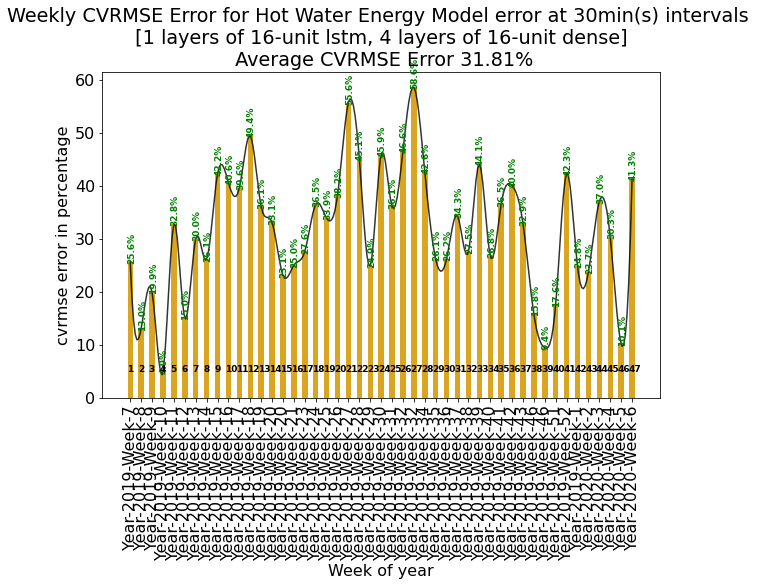

In [19]:
# Open a file
fo = open(path + "{}min Results_File.txt".format(5*period), "r")
print("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Year-{}-Week-{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    },
    'Test': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    }
}
xticklist = []
counter = 0
for line in lines:
    p = parse.parse(parse_format, line)
    stats[p[3]]['rmse'].append(float(p[4]))
    stats[p[5]]['cvrmse'].append(float(p[6]))
    stats[p[7]]['mae'].append(float(p[8]))
    if counter % 1 == 0:
        xticklist.append('Year-{}-Week-{}'.format(p[0], p[1]))
    counter += 1
fo.close()
cvrmse_list = stats['Test']['cvrmse']
cvrmse = sum(cvrmse_list) / len(cvrmse_list)
# from dataprocess import plotutils as pu
plot_args = dict(
    bars=cvrmse_list,
    color='goldenrod',
    bar_label='cvrmse',
    saveloc=path,
    smoothcurve=True,
    bar_annotate=True,
    saveplot=True,
    xlabel='Week of year',
    ylabel='cvrmse error in percentage',
    title=
    'Weekly CVRMSE Error for Hot Water Energy Model error at {5:}min(s) intervals \n [{0:} layers of {1:}-unit lstm, {2:} layers of {3:}-unit dense] \n Average CVRMSE Error {4:.2f}%'
    .format(modelconfig['lstm_no_layers'], modelconfig['lstm_hidden_units'],
            modelconfig['dense_no_layers'], modelconfig['dense_hidden_units'],
            cvrmse,5*period),
    xticklist=xticklist,
    plotwidth=10,
    plotheight=6,
    fontsize=16)
pu.single_bar_plot(**plot_args)

## Merge the pdfs together

In [20]:
# path where files are stored
pdfs_loc = path + 'detailedplots/'
# list all the files
flist = sorted(
    glob.glob(os.path.join(pdfs_loc, '*'))
)

In [21]:
from PyPDF2 import PdfFileMerger, PdfFileReader
 
# Call the PdfFileMerger
mergedObject = PdfFileMerger()
 
# I had 116 files in the folder that had to be merged into a single document
# Loop through all of them and append their pages
for filename in flist:
    mergedObject.append(PdfFileReader(filename, 'rb'))
    
#  Write all the files into a file which is named as shown below
mergedObject.write(path+'DetailedPredvsTarget.pdf')

In [22]:
from keras.utils import to_categorical

In [32]:
to_categorical(
np.array([
    [[0.0]],
    [[3.4]],
    [[0.0]],
    [[1.0]]
]))

array([[[1., 0., 0., 0.]],

       [[0., 0., 0., 1.]],

       [[1., 0., 0., 0.]],

       [[0., 1., 0., 0.]]], dtype=float32)